Code taken from source below and customised

https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/pytorch_lightning/6.%20Restructuring

## Libraries

In [75]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import tqdm                       # Progress bar
from torch.utils.data import random_split
import torchmetrics
from torchmetrics import Metric

import lightning as L                       # PyTorch Lightning
from lightning.pytorch.loggers import CSVLogger

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Configuration

In [76]:
# Training hyperparameters
INPUT_SIZE = 784
NUM_CLASSES = 10
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.1
MC_DROPOUT_SAMPLES = 50
BATCH_SIZE = 256
NUM_EPOCHS = 10

# Dataset
DATA_DIR = "dataset/"
NUM_WORKERS = 4

# Compute related
ACCELERATOR = "cpu"
DEVICES = 1

## Dataset
Using the LightningDataModule

https://lightning.ai/docs/pytorch/stable/data/datamodule.html

MNIST Dataset loaded from:

https://pytorch.org/vision/stable/datasets.html

In [77]:
class MnistDataModule(L.LightningDataModule):
    def __init__(self, data_dir, batch_size, num_workers):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

    def prepare_data(self):
        datasets.MNIST(self.data_dir, train=True, download=True)
        datasets.MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage):
        entire_dataset = datasets.MNIST(
            root=self.data_dir,
            train=True,
            transform=transforms.ToTensor(),
            download=False,
        )
        self.train_ds, self.val_ds = random_split(entire_dataset, [50000, 10000])
        self.test_ds = datasets.MNIST(
            root=self.data_dir,
            train=False,
            transform=transforms.ToTensor(),
            download=False,
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            persistent_workers=True,        # Considered to speed up the dataloader worker initialization
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            persistent_workers=True,        # Considered to speed up the dataloader worker initialization
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            persistent_workers=True,        # Considered to speed up the dataloader worker initialization
        )
    
    def predict_dataloader(self):
        return DataLoader(
            self.test_ds,                   # Use the entire test dataset for prediction
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            persistent_workers=True,        # Considered to speed up the dataloader worker initialization
        )


## Model
Using the LightningModule

https://lightning.ai/docs/pytorch/stable/common/lightning_module.html

####  FCM - Fully connected model

In [78]:
class FCM(L.LightningModule):
    def __init__(self, input_size, learning_rate, num_classes, dropout_rate, dropout_samples):
        super().__init__()
        self.lr = learning_rate
        self.num_classes = num_classes
        self.dropout_samples = dropout_samples

        # Layers
        self.fc1 = nn.Linear(input_size, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, self.num_classes)

        # Add a dropout layer between all the layers
        self.dropout = nn.Dropout(p=dropout_rate)
        
        # Loss function and metrics
        self.loss_fn = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=self.num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
    # Common step for training, validation, and test steps, to avoid code duplication
    def _common_step(self, batch, batch_idx):
        x, y = batch
        x = x.reshape(x.size(0), -1)
        scores = self.forward(x)
        loss = self.loss_fn(scores, y)
        return loss, scores, y

    def training_step(self, batch, batch_idx):
        loss, scores, y = self._common_step(batch, batch_idx)
        accuracy = self.accuracy(scores, y)
        self.log_dict({"train_loss": loss,"train_acc": accuracy},
                      on_step=False,
                      on_epoch=True,
                      prog_bar=True,
                      )
        return {"loss": loss, "scores": scores, "y": y}

    def validation_step(self, batch, batch_idx):
        loss, scores, y = self._common_step(batch, batch_idx)
        accuracy = self.accuracy(scores, y)
        self.log_dict({"val_loss": loss,"val_acc": accuracy},
                      on_step=False,
                      on_epoch=True,
                      prog_bar=True,
                      )
        return {"loss": loss, "scores": scores, "y": y}

    def test_step(self, batch, batch_idx):
        loss, scores, y = self._common_step(batch, batch_idx)
        self.log("test_loss", loss)
        return loss

    # Prediction step applying Monte Carlo Dropout
    def predict_step(self, batch, batch_idx):
        x, y = batch
        x = x.reshape(x.size(0), -1)
        # Enable dropout
        self.dropout.train()
        predictions = torch.zeros(self.dropout_samples, x.size(0), self.num_classes)
        for i in range(self.dropout_samples):
            scores = self.forward(x)
            predictions[i] = F.softmax(scores, dim=1)
        return predictions

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr)

## Training
Using the Trainer

https://lightning.ai/docs/pytorch/stable/common/trainer.html

In [79]:
model = FCM(input_size=INPUT_SIZE,
            learning_rate=LEARNING_RATE,
            num_classes=NUM_CLASSES,
            dropout_rate=DROPOUT_RATE,
            dropout_samples=MC_DROPOUT_SAMPLES,
            )

In [80]:
dm = MnistDataModule(data_dir=DATA_DIR,
                     batch_size=BATCH_SIZE,
                     num_workers=NUM_WORKERS,
                     )

In [81]:
logger = CSVLogger("logs", name="FCM_MNIST")

trainer = L.Trainer(# accelerator=ACCELERATOR,
                    # devices=DEVICES,
                    max_epochs=NUM_EPOCHS,
                    logger=logger,
                    # profiler="simple",
                    )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [82]:
trainer.fit(model, dm)


  | Name     | Type               | Params
------------------------------------------------
0 | fc1      | Linear             | 15.7 K
1 | fc2      | Linear             | 420   
2 | fc3      | Linear             | 210   
3 | dropout  | Dropout            | 0     
4 | loss_fn  | CrossEntropyLoss   | 0     
5 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
16.3 K    Trainable params
0         Non-trainable params
16.3 K    Total params
0.065     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


## Logged metrics

#### Step by step

In [83]:
# Import the csv file in a pandas dataframe to visualize the metrics
# Select the version folder
version = 0
df = pd.read_csv(f"logs/FCM_MNIST/version_{version}/metrics.csv")

# Drop the NaN values, summarize the metrics for each epoch
df = df.groupby("epoch").median()

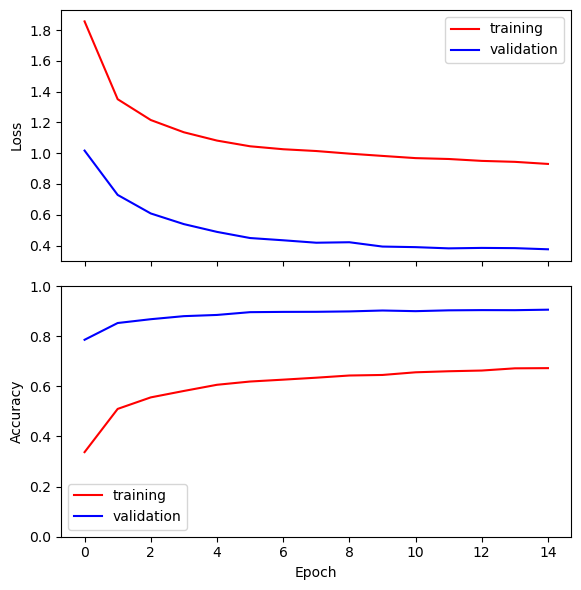

In [84]:
# Plot the loss and accuracy
fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

# Plot the loss
ax[0].plot(df.index, df["train_loss"], label="training", color="r")
ax[0].plot(df.index, df["val_loss"], label="validation", color="b")

# Plot the accuracy
ax[1].plot(df.index, df["train_acc"], label="training", color="r")
ax[1].plot(df.index, df["val_acc"], label="validation", color="b")
# Set the y-axis limits
ax[1].set_ylim(0, 1)

# Set the labels
ax[0].set_ylabel("Loss")
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Epoch")
ax[0].legend()
ax[1].legend()

plt.tight_layout()
plt.show()

In [85]:
# Summarize the import and plot of the metrics in a single function
def plot_metrics(version):
    df = pd.read_csv(f"logs/FCM_MNIST/version_{version}/metrics.csv")
    df = df.groupby("epoch").median()

    fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

    ax[0].plot(df.index, df["train_loss"], label="training", color="r")
    ax[0].plot(df.index, df["val_loss"], label="validation", color="b")

    ax[1].plot(df.index, df["train_acc"], label="training", color="r")
    ax[1].plot(df.index, df["val_acc"], label="validation", color="b")
    ax[1].set_ylim(0, 1)

    ax[0].set_ylabel("Loss")
    ax[1].set_ylabel("Accuracy")
    ax[1].set_xlabel("Epoch")
    ax[0].legend()
    ax[1].legend()

    plt.tight_layout()
    plt.show()

#### Function

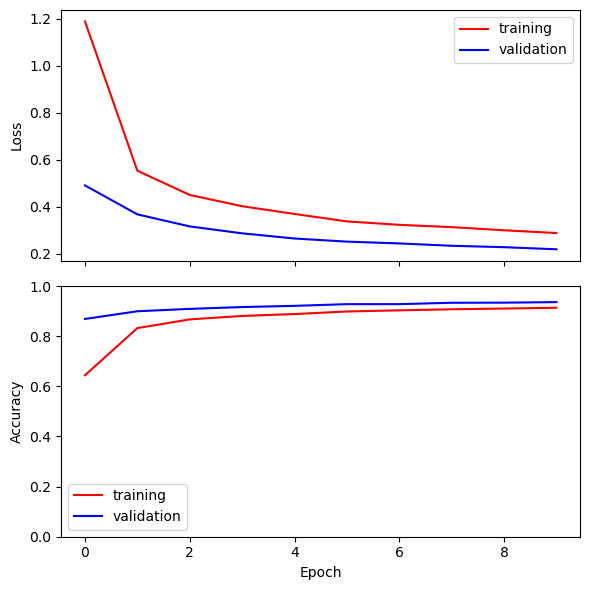

In [94]:
plot_metrics(7)

## Make predictions and calculate uncertainty

In [87]:
pred = trainer.predict(model, dm)

Predicting: |          | 0/? [00:00<?, ?it/s]

#### Step by step

In [88]:
# Create a tensor from the prediction list
predictions = pred[0]
predictions.shape

torch.Size([50, 256, 10])

In [89]:
# Calculate the mean softmax probabilities
# Take the class with the highest probability
idx_max = predictions.mean(dim=0).argmax(dim=1)

In [90]:
# Calculate the mean softmax probabilities
# Take the column of std according to the idx_max
softmax_max = predictions.mean(dim=0)[torch.arange(predictions.size(1)), idx_max]

In [91]:
# Calculate the standard deviation of the softmax probabilities
# Take the column of std according to the idx_max
std_max = predictions.std(dim=0)[torch.arange(predictions.size(1)), idx_max]

In [92]:
# Create a dataframe with the results
df = pd.DataFrame({"Prediction": idx_max.numpy(),
                   "Target":dm.test_ds.targets[0:BATCH_SIZE].numpy(),
                   "Softmax_UC": 1 - softmax_max.numpy(),
                   "Dropout_UC": std_max.numpy(),
                   })

df.head()

,Prediction,Target,Softmax_UC,Dropout_UC
0,7,7,0.017075,0.043411
1,2,2,0.010142,0.020796
2,1,1,0.059332,0.090107
3,0,0,0.014551,0.035695
4,4,4,0.076176,0.098647


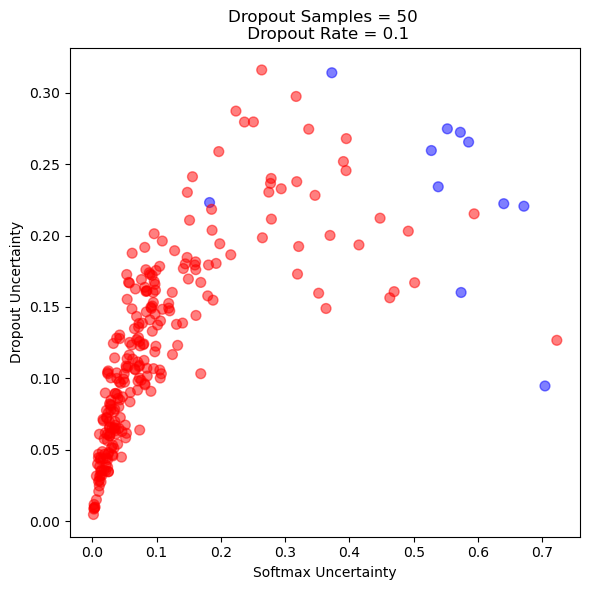

In [93]:
# Plot the Softmax_UC against the Dropout_UC
plt.figure(figsize=(6, 6))
plt.scatter(df["Softmax_UC"],
            df["Dropout_UC"],
            c=df["Prediction"] == df["Target"],
            cmap="bwr",
            alpha=0.5,
            s=50)

plt.xlabel("Softmax Uncertainty")
plt.ylabel("Dropout Uncertainty")
plt.title(f"Dropout Samples = {MC_DROPOUT_SAMPLES} \n Dropout Rate = {DROPOUT_RATE}")

# Save the plot
plt.tight_layout()
plt.savefig(f"plots/Samples_{MC_DROPOUT_SAMPLES}_Rate_{DROPOUT_RATE}.png")

In [95]:
# Check the correlation between the Softmax_UC and the Dropout_UC
df[["Softmax_UC", "Dropout_UC"]].corr()

,Softmax_UC,Dropout_UC
Softmax_UC,1.000000,0.688127
Dropout_UC,0.688127,1.000000
